##  MTA turnstile 

Data between February, 2021 and June 2021

In [1]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 


In [3]:
import seaborn as sns

In [4]:
from datetime import datetime, timedelta

In [133]:
engine = create_engine("sqlite:///C:/Users/12157/mta_data.db")

In [6]:
pd.read_sql('SELECT count(Distinct Date) FROM mta_data;', engine)


count(Distinct Date)
0                   119

The data consist of 119 days between February, 2021 and June 2021. 

In [7]:
pd.read_sql('SELECT DISTINCT STATION FROM mta_data GROUP BY STATION;', engine)

STATION
0               1 AV
1             103 ST
2      103 ST-CORONA
3             104 ST
4             110 ST
..               ...
374         WOODLAWN
375  WORLD TRADE CTR
376    WTC-CORTLANDT
377          YORK ST
378        ZEREGA AV

[379 rows x 1 columns]

In [8]:
pd.read_sql('SELECT DISTINCT STATION, COUNT(DISTINCT DATE), COUNT(DISTINCT TIME) FROM mta_data GROUP BY STATION ORDER BY COUNT(DISTINCT DATE) DESC,COUNT(DISTINCT TIME)  DESC;', engine)

STATION  COUNT(DISTINCT DATE)  COUNT(DISTINCT TIME)
0     JOURNAL SQUARE                   119                  9865
1       PATH NEW WTC                   119                  9114
2         CITY / BUS                   119                  8190
3         LACKAWANNA                   119                  7844
4       GROVE STREET                   119                  7202
..               ...                   ...                   ...
374        ZEREGA AV                   119                    12
375  116 ST-COLUMBIA                   117                    12
376  BAY RIDGE-95 ST                   116                    30
377  85 ST-FOREST PK                   116                    17
378    ORCHARD BEACH                     8                    14

[379 rows x 3 columns]

There are 379 unique stations. Not all stations have records over the selected time period. This will be investigated further at the data cleaning section, one reason might be duplication in station names.

Each turnstile is identified by a combination of the C/A, UNIT and  SCP columns. Below I will check if there are any dupplicates.

In [9]:
pd.read_sql('SELECT [C/A] ,UNIT,SCP,DATE,TIME,count(ENTRIES) FROM mta_data group by [C/A] ,UNIT,SCP,DATE,TIME having count(ENTRIES) > 1 order by count(ENTRIES) DESC ;', engine)
# duplicates


C/A  UNIT       SCP        DATE      TIME  count(ENTRIES)
0     B024  R211  00-05-00  05/01/2021  00:00:00               2
1     B024  R211  00-05-00  05/01/2021  08:00:00               2
2     B024  R211  00-05-00  05/01/2021  12:00:00               2
3     B024  R211  00-05-00  05/01/2021  16:00:00               2
4     B024  R211  00-05-00  05/01/2021  20:00:00               2
..     ...   ...       ...         ...       ...             ...
102   R145  R032  00-00-02  02/05/2021  07:00:00               2
103  R160A  R164  00-06-00  02/08/2021  12:00:00               2
104   R314  R406  00-00-02  05/28/2021  05:00:00               2
105   R417  R222  00-00-01  03/26/2021  05:00:00               2
106   R417  R222  00-03-01  03/26/2021  05:00:00               2

[107 rows x 6 columns]

There are 107 turnstiles having duplicate records per date and time. These records will be investaged and cleaned in data cleaning section.

In [10]:
pd.read_sql('SELECT * FROM mta_data WHERE [C/A] ="B024" and UNIT = "R211" and SCP="00-05-00" and DATE ="05/01/2021" and TIME = "12:00:00";', engine)


C/A  UNIT       SCP    STATION LINENAME DIVISION        DATE      TIME  \
0  B024  R211  00-05-00  KINGS HWY       BQ      BMT  05/01/2021  12:00:00   
1  B024  R211  00-05-00  KINGS HWY       BQ      BMT  05/01/2021  12:00:00   

         DESC  ENTRIES  EXITS  
0     REGULAR   262152      0  
1  RECOVR AUD       12      0

In [11]:
pd.read_sql('SELECT * FROM mta_data WHERE [C/A] ="B024" and UNIT = "R211" and SCP="00-05-00" and DATE ="05/01/2021" and TIME = "20:00:00";', engine)


C/A  UNIT       SCP    STATION LINENAME DIVISION        DATE      TIME  \
0  B024  R211  00-05-00  KINGS HWY       BQ      BMT  05/01/2021  20:00:00   
1  B024  R211  00-05-00  KINGS HWY       BQ      BMT  05/01/2021  20:00:00   

         DESC  ENTRIES  EXITS  
0     REGULAR   262152      0  
1  RECOVR AUD       13      0

It looks like the duplicate occurs when there is a "RECOVR AUD" entry referring a missed audit that was recovered. 

In [12]:
pd.read_sql('SELECT Count(STATION) FROM mta_data WHERE DESC="RECOVR AUD";', engine)


Count(STATION)
0           13914

Creating Pandas data frame

In [13]:
df = pd.read_sql('Select * from mta_data ',engine) 


In [14]:
df.head()

C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  05/22/2021  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  05/22/2021  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  05/22/2021  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  05/22/2021  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  05/22/2021  16:00:00   

         DESC  ENTRIES    EXITS  
0     REGULAR  7575503  2588978  
1  RECOVR AUD  7575515  2588982  
2     REGULAR  7575523  2588989  
3     REGULAR  7575557  2588996  
4     REGULAR  7575630  2589008

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554428 entries, 0 to 3554427
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 298.3+ MB


In [16]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

Converting date and time information to datetime objects by combining DATE and TIME columns into a single new column of the datetime datatype.

In [17]:
df['DATE_TIME'] = pd.to_datetime(df.DATE+ ' ' + df.TIME,format='%m/%d/%Y %H:%M:%S')

In [18]:
df['DATE_TIME'].value_counts().sort_index()

2021-01-30 00:00:00    1883
2021-01-30 00:00:27       1
2021-01-30 00:00:57       1
2021-01-30 00:01:21       1
2021-01-30 00:01:22       1
                       ... 
2021-05-28 23:56:02       1
2021-05-28 23:56:11       1
2021-05-28 23:57:31       1
2021-05-28 23:57:57       1
2021-05-28 23:58:12       1
Name: DATE_TIME, Length: 226118, dtype: int64

Creating a new variable which is unique  pre each turnstile by combining C/A, UNIT, SCP columns into a single new column of the object datatype. 

In [19]:
df['TURNSTILE'] =df['C/A']+'-'+df['UNIT']+'-'+df['SCP']

In [20]:
df.head()

C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  05/22/2021  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  05/22/2021  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  05/22/2021  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  05/22/2021  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  05/22/2021  16:00:00   

         DESC  ENTRIES    EXITS           DATE_TIME           TURNSTILE  
0     REGULAR  7575503  2588978 2021-05-22 00:00:00  A002-R051-02-00-00  
1  RECOVR AUD  7575515  2588982 2021-05-22 04:00:00  A002-R051-02-00-00  
2     REGULAR  7575523  2588989 2021-05-22 08:00:00  A002-R051-02-00-00  
3     REGULAR  7575557  2588996 2021-05-22 12:00:00  A002-R051-02-00-00  
4     REGULAR  7575630  2589008 2021-05-22 16:00:00  A002-R051-02-00-00

# 1. Data Cleaning

Checking duplicates with pandas that I observed before.

In [21]:
(df.groupby(['TURNSTILE', 'DATE_TIME']).ENTRIES.count().reset_index().sort_values("ENTRIES", ascending=False)).head(10)

TURNSTILE           DATE_TIME  ENTRIES
2390529  R145-R032-00-00-02 2021-02-02 07:00:00        2
3107321  R417-R222-00-03-01 2021-03-26 05:00:00        2
1089771  N100-R252-00-00-00 2021-03-09 07:00:00        2
1089772  N100-R252-00-00-00 2021-03-09 11:00:00        2
1089773  N100-R252-00-00-00 2021-03-09 15:00:00        2
301779   B024-R211-00-05-00 2021-05-03 08:00:00        2
301780   B024-R211-00-05-00 2021-05-03 12:00:00        2
301781   B024-R211-00-05-00 2021-05-03 16:00:00        2
301782   B024-R211-00-05-00 2021-05-03 20:00:00        2
301783   B024-R211-00-05-00 2021-05-04 00:00:00        2

In [22]:
df.shape # before removing duplicates

(3554428, 13)

In [23]:
df.sort_values(["TURNSTILE", "STATION", "DATE_TIME"], inplace=True, ascending=False)
df.drop_duplicates(subset=["TURNSTILE", "STATION", "DATE_TIME"], inplace=True)

In [24]:
df.shape #after removing duplicates (110 duplicates are removed )

(3554321, 13)

In [25]:
# Sanity check to make sure all duplicates have been dropped
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

C/A  UNIT       SCP         STATION           DATE_TIME  ENTRIES
0        A002  R051  02-00-00           59 ST 2021-01-30 03:00:00        1
2369552  R138  R293  00-05-01  34 ST-PENN STA 2021-04-17 18:00:00        1
2369541  R138  R293  00-05-01  34 ST-PENN STA 2021-04-15 22:00:00        1
2369542  R138  R293  00-05-01  34 ST-PENN STA 2021-04-16 02:00:00        1
2369543  R138  R293  00-05-01  34 ST-PENN STA 2021-04-16 06:00:00        1

In [26]:
df.DESC.value_counts()

REGULAR       3540514
RECOVR AUD      13807
Name: DESC, dtype: int64

Checking missing values :No missing values

In [27]:
df.isna().sum()

C/A          0
UNIT         0
SCP          0
STATION      0
LINENAME     0
DIVISION     0
DATE         0
TIME         0
DESC         0
ENTRIES      0
EXITS        0
DATE_TIME    0
TURNSTILE    0
dtype: int64

# 2. Exploratory Data Analysis and More Data Cleaning 

In [28]:
df.describe()

ENTRIES         EXITS
count  3.554321e+06  3.554321e+06
mean   4.202480e+07  3.377647e+07
std    2.185682e+08  1.937419e+08
min    0.000000e+00  0.000000e+00
25%    2.203420e+05  9.313700e+04
50%    1.469674e+06  8.818340e+05
75%    6.142145e+06  4.040182e+06
max    2.147432e+09  2.123039e+09

All the entry and exit values should be greater than 0 since the cumulative data values should increase or stay at the same value. However, as seen in the descriptive statistics there are zeros on both entries and exits columns. 
The other issue observed from the descriptive statistics is the data has outlier values - the maximum entry (exit) is about a million time higher than the 75% which is abnormally high. 

In [29]:
df[(df.ENTRIES == 0)]

C/A  UNIT       SCP        STATION LINENAME DIVISION        DATE  \
208869   TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208868   TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208867   TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208866   TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208865   TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
...        ...   ...       ...            ...      ...      ...         ...   
3345773   A002  R051  02-05-01          59 ST  NQR456W      BMT  01/30/2021   
3345772   A002  R051  02-05-01          59 ST  NQR456W      BMT  01/30/2021   
3345771   A002  R051  02-05-01          59 ST  NQR456W      BMT  01/30/2021   
3345770   A002  R051  02-05-01          59 ST  NQR456W      BMT  01/30/2021   
3345769   A002  R051  02-05-01          59 ST  NQR456W      BMT  01/30/2021   

             TIME        DESC  ENTRIES  EXITS           DATE_TIME  \
208869   21:00:00     REGULAR        0      0 2021-05-28 21:00:00   
208868   17:00:00     REGULAR        0      0 2021-05-28 17:00:00   
208867   13:00:00     REGULAR        0      0 2021-05-28 13:00:00   
208866   09:00:00     REGULAR        0      0 2021-05-28 09:00:00   
208865   08:20:35     REGULAR        0      0 2021-05-28 08:20:35   
...           ...         ...      ...    ...                 ...   
3345773  19:00:00     REGULAR        0    890 2021-01-30 19:00:00   
3345772  15:00:00  RECOVR AUD        0    890 2021-01-30 15:00:00   
3345771  11:00:00     REGULAR        0    890 2021-01-30 11:00:00   
3345770  07:00:00     REGULAR        0    890 2021-01-30 07:00:00   
3345769  03:00:00     REGULAR        0    890 2021-01-30 03:00:00   

                   TURNSTILE  
208869   TRAM2-R469-00-05-00  
208868   TRAM2-R469-00-05-00  
208867   TRAM2-R469-00-05-00  
208866   TRAM2-R469-00-05-00  
208865   TRAM2-R469-00-05-00  
...                      ...  
3345773   A002-R051-02-05-01  
3345772   A002-R051-02-05-01  
3345771   A002-R051-02-05-01  
3345770   A002-R051-02-05-01  
3345769   A002-R051-02-05-01  

[49437 rows x 13 columns]

In [30]:
df[(df.EXITS == 0)]

C/A  UNIT       SCP        STATION LINENAME DIVISION        DATE  \
208869   TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208868   TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208867   TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208866   TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208865   TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
...        ...   ...       ...            ...      ...      ...         ...   
3345731   A002  R051  02-05-00          59 ST  NQR456W      BMT  01/30/2021   
3345730   A002  R051  02-05-00          59 ST  NQR456W      BMT  01/30/2021   
3345729   A002  R051  02-05-00          59 ST  NQR456W      BMT  01/30/2021   
3345728   A002  R051  02-05-00          59 ST  NQR456W      BMT  01/30/2021   
3345727   A002  R051  02-05-00          59 ST  NQR456W      BMT  01/30/2021   

             TIME        DESC  ENTRIES  EXITS           DATE_TIME  \
208869   21:00:00     REGULAR        0      0 2021-05-28 21:00:00   
208868   17:00:00     REGULAR        0      0 2021-05-28 17:00:00   
208867   13:00:00     REGULAR        0      0 2021-05-28 13:00:00   
208866   09:00:00     REGULAR        0      0 2021-05-28 09:00:00   
208865   08:20:35     REGULAR        0      0 2021-05-28 08:20:35   
...           ...         ...      ...    ...                 ...   
3345731  19:00:00     REGULAR   524405      0 2021-01-30 19:00:00   
3345730  15:00:00  RECOVR AUD   524405      0 2021-01-30 15:00:00   
3345729  11:00:00     REGULAR   524405      0 2021-01-30 11:00:00   
3345728  07:00:00     REGULAR   524405      0 2021-01-30 07:00:00   
3345727  03:00:00     REGULAR   524405      0 2021-01-30 03:00:00   

                   TURNSTILE  
208869   TRAM2-R469-00-05-00  
208868   TRAM2-R469-00-05-00  
208867   TRAM2-R469-00-05-00  
208866   TRAM2-R469-00-05-00  
208865   TRAM2-R469-00-05-00  
...                      ...  
3345731   A002-R051-02-05-00  
3345730   A002-R051-02-05-00  
3345729   A002-R051-02-05-00  
3345728   A002-R051-02-05-00  
3345727   A002-R051-02-05-00  

[142464 rows x 13 columns]

In [31]:
df_zeros = df[(df.ENTRIES == 0) & (df.EXITS == 0)]
df_zeros.head()

C/A  UNIT       SCP        STATION LINENAME DIVISION        DATE  \
208869  TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208868  TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208867  TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208866  TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   
208865  TRAM2  R469  00-05-00  RIT-ROOSEVELT        R      RIT  05/28/2021   

            TIME     DESC  ENTRIES  EXITS           DATE_TIME  \
208869  21:00:00  REGULAR        0      0 2021-05-28 21:00:00   
208868  17:00:00  REGULAR        0      0 2021-05-28 17:00:00   
208867  13:00:00  REGULAR        0      0 2021-05-28 13:00:00   
208866  09:00:00  REGULAR        0      0 2021-05-28 09:00:00   
208865  08:20:35  REGULAR        0      0 2021-05-28 08:20:35   

                  TURNSTILE  
208869  TRAM2-R469-00-05-00  
208868  TRAM2-R469-00-05-00  
208867  TRAM2-R469-00-05-00  
208866  TRAM2-R469-00-05-00  
208865  TRAM2-R469-00-05-00

In [32]:
df_zeros.shape

(1365, 13)

There are 1365 data records which have zero for both ENTRIES and EXITS. Moreover, the number of zero records are 49437 in ENTRIES column and 142464 in EXITS column.  
The below table shows how many zero records (both in ENTRIES and EXITS) per turnstile. 

Stations with the most zero records are 33-St,Manhattan and Aqueduct Racetrack, Queens Stations. For these two stations, almost all zeros recorded during "REGULAR" scheduled audit events. 

At this point, I will keep the records that have zeros in both ENTRIES and EXITS due to the lack of explanation. 

In [33]:
(df_zeros.groupby(['C/A', 'UNIT', 'SCP','STATION','DIVISION','TURNSTILE']).count())

LINENAME  \
C/A   UNIT SCP      STATION         DIVISION TURNSTILE                       
A049  R088 02-00-02 CORTLANDT ST    BMT      A049-R088-02-00-02          1   
B025  R150 00-05-00 AVENUE U        BMT      B025-R150-00-05-00        103   
H007A R248 02-05-00 1 AV            BMT      H007A-R248-02-05-00         4   
N012  R035 01-05-00 168 ST          IND      N012-R035-01-05-00        147   
N083  R138 01-05-00 W 4 ST-WASH SQ  IND      N083-R138-01-05-00          9   
N114  R297 01-05-01 FRANKLIN AV     IND      N114-R297-01-05-01          1   
N181A R464 00-05-00 AQUEDUCT RACETR IND      N181A-R464-00-05-00       386   
N339A R114 00-00-00 PARSONS BLVD    IND      N339A-R114-00-00-00         1   
N526  R142 02-00-00 DELANCEY/ESSEX  IND      N526-R142-02-00-00          1   
N544  R289 01-05-01 FT HAMILTON PKY IND      N544-R289-01-05-01          1   
PTH02 R544 00-06-00 HARRISON        PTH      PTH02-R544-00-06-00         1   
PTH03 R552 00-05-03 JOURNAL SQUARE  PTH      PTH03-R552-00-05-03         1   
PTH04 R551 00-04-04 GROVE STREET    PTH      PTH04-R551-00-04-04         1   
PTH11 R545 00-00-02 14TH STREET     PTH      PTH11-R545-00-00-02         3   
PTH12 R542 00-04-01 TWENTY THIRD ST PTH      PTH12-R542-00-04-01         1   
PTH13 R541 00-00-00 THIRTY ST       PTH      PTH13-R541-00-00-00         1   
PTH17 R541 01-00-00 THIRTY THIRD ST PTH      PTH17-R541-01-00-00       679   
PTH21 R540 01-00-02 PATH WTC 2      PTH      PTH21-R540-01-00-02         1   
PTH22 R540 00-00-05 PATH NEW WTC    PTH      PTH22-R540-00-00-05         1   
           00-01-04 PATH NEW WTC    PTH      PTH22-R540-00-01-04         1   
           00-03-04 PATH NEW WTC    PTH      PTH22-R540-00-03-04         1   
R205A R014 04-05-00 FULTON ST       IRT      R205A-R014-04-05-00         1   
R532  R328 00-06-02 METS-WILLETS PT IRT      R532-R328-00-06-02          3   
TRAM2 R469 00-05-00 RIT-ROOSEVELT   RIT      TRAM2-R469-00-05-00        16   

                                                                  DATE  TIME  \
C/A   UNIT SCP      STATION         DIVISION TURNSTILE                         
A049  R088 02-00-02 CORTLANDT ST    BMT      A049-R088-02-00-02      1     1   
B025  R150 00-05-00 AVENUE U        BMT      B025-R150-00-05-00    103   103   
H007A R248 02-05-00 1 AV            BMT      H007A-R248-02-05-00     4     4   
N012  R035 01-05-00 168 ST          IND      N012-R035-01-05-00    147   147   
N083  R138 01-05-00 W 4 ST-WASH SQ  IND      N083-R138-01-05-00      9     9   
N114  R297 01-05-01 FRANKLIN AV     IND      N114-R297-01-05-01      1     1   
N181A R464 00-05-00 AQUEDUCT RACETR IND      N181A-R464-00-05-00   386   386   
N339A R114 00-00-00 PARSONS BLVD    IND      N339A-R114-00-00-00     1     1   
N526  R142 02-00-00 DELANCEY/ESSEX  IND      N526-R142-02-00-00      1     1   
N544  R289 01-05-01 FT HAMILTON PKY IND      N544-R289-01-05-01      1     1   
PTH02 R544 00-06-00 HARRISON        PTH      PTH02-R544-00-06-00     1     1   
PTH03 R552 00-05-03 JOURNAL SQUARE  PTH      PTH03-R552-00-05-03     1     1   
PTH04 R551 00-04-04 GROVE STREET    PTH      PTH04-R551-00-04-04     1     1   
PTH11 R545 00-00-02 14TH STREET     PTH      PTH11-R545-00-00-02     3     3   
PTH12 R542 00-04-01 TWENTY THIRD ST PTH      PTH12-R542-00-04-01     1     1   
PTH13 R541 00-00-00 THIRTY ST       PTH      PTH13-R541-00-00-00     1     1   
PTH17 R541 01-00-00 THIRTY THIRD ST PTH      PTH17-R541-01-00-00   679   679   
PTH21 R540 01-00-02 PATH WTC 2      PTH      PTH21-R540-01-00-02     1     1   
PTH22 R540 00-00-05 PATH NEW WTC    PTH      PTH22-R540-00-00-05     1     1   
           00-01-04 PATH NEW WTC    PTH      PTH22-R540-00-01-04     1     1   
           00-03-04 PATH NEW WTC    PTH      PTH22-R540-00-03-04     1     1   
R205A R014 04-05-00 FULTON ST       IRT      R205A-R014-04-05-00     1     1   
R532  R328 00-06-02 METS-WILLETS PT IRT      R532-R328-00-06-02      3     3   
TRAM2 R469 00-05-00 RIT-ROOSEVELT   R

In [34]:
pd.read_sql('SELECT count(ENTRIES) FROM mta_data WHERE STATION="THIRTY THIRD ST";', engine)

count(ENTRIES)
0           12116

In [35]:
pd.read_sql('SELECT * FROM mta_data WHERE STATION="THIRTY THIRD ST" and ENTRIES = 0 and EXITS = 0;', engine)

C/A  UNIT       SCP          STATION LINENAME DIVISION        DATE  \
0    PTH17  R541  01-00-00  THIRTY THIRD ST        1      PTH  05/22/2021   
1    PTH17  R541  01-00-00  THIRTY THIRD ST        1      PTH  05/22/2021   
2    PTH17  R541  01-00-00  THIRTY THIRD ST        1      PTH  05/22/2021   
3    PTH17  R541  01-00-00  THIRTY THIRD ST        1      PTH  05/22/2021   
4    PTH17  R541  01-00-00  THIRTY THIRD ST        1      PTH  05/22/2021   
..     ...   ...       ...              ...      ...      ...         ...   
674  PTH17  R541  01-00-00  THIRTY THIRD ST        1      PTH  02/05/2021   
675  PTH17  R541  01-00-00  THIRTY THIRD ST        1      PTH  02/05/2021   
676  PTH17  R541  01-00-00  THIRTY THIRD ST        1      PTH  02/05/2021   
677  PTH17  R541  01-00-00  THIRTY THIRD ST        1      PTH  02/05/2021   
678  PTH17  R541  01-00-00  THIRTY THIRD ST        1      PTH  02/05/2021   

         TIME     DESC  ENTRIES  EXITS  
0    00:06:16  REGULAR        0      0  
1    04:18:16  REGULAR        0      0  
2    08:30:16  REGULAR        0      0  
3    12:42:16  REGULAR        0      0  
4    16:54:16  REGULAR        0      0  
..        ...      ...      ...    ...  
674  05:02:49  REGULAR        0      0  
675  09:14:49  REGULAR        0      0  
676  13:26:49  REGULAR        0      0  
677  17:38:49  REGULAR        0      0  
678  21:50:49  REGULAR        0      0  

[679 rows x 11 columns]

In [36]:
(pd.read_sql('SELECT * FROM mta_data WHERE STATION="THIRTY THIRD ST" and ENTRIES = 0 and EXITS = 0;', engine)).DESC.describe()

count         679
unique          1
top       REGULAR
freq          679
Name: DESC, dtype: object

In [37]:
pd.read_sql('SELECT count(ENTRIES) FROM mta_data WHERE STATION="AQUEDUCT RACETR";', engine)

count(ENTRIES)
0            4230

In [38]:
(pd.read_sql('SELECT * FROM mta_data WHERE STATION="AQUEDUCT RACETR";', engine)).DESC.describe()

count        4230
unique          2
top       REGULAR
freq         4223
Name: DESC, dtype: object

# 3. Modeling 

I will use the last record of ENTRIES(EXITS) value for each day, for each unique turnstile to represent the daily ENTRIES(EXITS).  

In [39]:
mta_daily = (df.groupby(["TURNSTILE","STATION", "DATE"],as_index=False)[['ENTRIES','EXITS']].first())
mta_daily.head()

TURNSTILE STATION        DATE  ENTRIES    EXITS
0  A002-R051-02-00-00   59 ST  01/30/2021  7524821  2564823
1  A002-R051-02-00-00   59 ST  01/31/2021  7525089  2564914
2  A002-R051-02-00-00   59 ST  02/01/2021  7525260  2565032
3  A002-R051-02-00-00   59 ST  02/02/2021  7525600  2565208
4  A002-R051-02-00-00   59 ST  02/03/2021  7526164  2565484

In [40]:
mta_daily['DATE'] = pd.to_datetime(mta_daily.DATE)


In [41]:
mta_daily.describe()

ENTRIES         EXITS
count  5.940970e+05  5.940970e+05
mean   4.189171e+07  3.367405e+07
std    2.182497e+08  1.934693e+08
min    0.000000e+00  0.000000e+00
25%    2.153240e+05  9.134800e+04
50%    1.451983e+06  8.653600e+05
75%    6.116858e+06  4.018029e+06
max    2.147432e+09  2.123038e+09

In [42]:
type(mta_daily)

pandas.core.frame.DataFrame

In [43]:
mta_daily['no_entry']= mta_daily.sort_values(['TURNSTILE','DATE'],ascending = (False, True)).groupby(['TURNSTILE'])['ENTRIES'].diff()
mta_daily['no_exits']= mta_daily.sort_values(['TURNSTILE','DATE'],ascending = (False, True)).groupby(['TURNSTILE'])['EXITS'].diff()


In [44]:
mta_daily.head(15)

TURNSTILE STATION       DATE  ENTRIES    EXITS  no_entry  \
0   A002-R051-02-00-00   59 ST 2021-01-30  7524821  2564823       NaN   
1   A002-R051-02-00-00   59 ST 2021-01-31  7525089  2564914     268.0   
2   A002-R051-02-00-00   59 ST 2021-02-01  7525260  2565032     171.0   
3   A002-R051-02-00-00   59 ST 2021-02-02  7525600  2565208     340.0   
4   A002-R051-02-00-00   59 ST 2021-02-03  7526164  2565484     564.0   
5   A002-R051-02-00-00   59 ST 2021-02-04  7526683  2565733     519.0   
6   A002-R051-02-00-00   59 ST 2021-02-05  7527228  2565986     545.0   
7   A002-R051-02-00-00   59 ST 2021-02-06  7527688  2566148     460.0   
8   A002-R051-02-00-00   59 ST 2021-02-07  7527954  2566243     266.0   
9   A002-R051-02-00-00   59 ST 2021-02-08  7528485  2566485     531.0   
10  A002-R051-02-00-00   59 ST 2021-02-09  7529019  2566730     534.0   
11  A002-R051-02-00-00   59 ST 2021-02-10  7529531  2567004     512.0   
12  A002-R051-02-00-00   59 ST 2021-02-11  7530103  2567259     572.0   
13  A002-R051-02-00-00   59 ST 2021-02-12  7530656  2567495     553.0   
14  A002-R051-02-00-00   59 ST 2021-02-13  7531045  2567659     389.0   

    no_exits  
0        NaN  
1       91.0  
2      118.0  
3      176.0  
4      276.0  
5      249.0  
6      253.0  
7      162.0  
8       95.0  
9      242.0  
10     245.0  
11     274.0  
12     255.0  
13     236.0  
14     164.0

In [45]:
mta_daily.describe()

ENTRIES         EXITS      no_entry      no_exits
count  5.940970e+05  5.940970e+05  5.890380e+05  5.890380e+05
mean   4.189171e+07  3.367405e+07 -4.811746e+03 -4.170336e+03
std    2.182497e+08  1.934693e+08  5.776224e+06  5.594621e+06
min    0.000000e+00  0.000000e+00 -1.604323e+09 -1.804895e+09
25%    2.153240e+05  9.134800e+04  5.600000e+01  5.500000e+01
50%    1.451983e+06  8.653600e+05  2.080000e+02  1.940000e+02
75%    6.116858e+06  4.018029e+06  4.340000e+02  4.490000e+02
max    2.147432e+09  2.123038e+09  2.139011e+09  2.005379e+09

Let's investigate the descriptive statistics of the no_entry column which represent the number of daily entries per turnstile. These statistics show that the records have several issues that need to be addressed. First of all, the average values of daily entries is negative which is not possible for the records which represent the number of occurences. Moreover, the data has outliers, eg. the maximum records are abnormally higher than the rest of the data.

Let's check couple of instances that have negative number of entries: 

In [46]:
df[(df.TURNSTILE=='A011-R080-01-03-00')& ((df.DATE =='01/30/2021')|(df.DATE =='01/31/2021')) ][['TURNSTILE', 'DATE_TIME', 'ENTRIES']].head(15)

TURNSTILE           DATE_TIME    ENTRIES
3346997  A011-R080-01-03-00 2021-01-31 23:00:00  885624026
3346996  A011-R080-01-03-00 2021-01-31 19:00:00  885624053
3346995  A011-R080-01-03-00 2021-01-31 15:00:00  885624093
3346994  A011-R080-01-03-00 2021-01-31 11:00:00  885624109
3346993  A011-R080-01-03-00 2021-01-31 07:00:00  885624111
3346992  A011-R080-01-03-00 2021-01-31 03:00:00  885624111
3346991  A011-R080-01-03-00 2021-01-30 23:00:00  885624120
3346990  A011-R080-01-03-00 2021-01-30 19:00:00  885624164
3346989  A011-R080-01-03-00 2021-01-30 15:00:00  885624214
3346988  A011-R080-01-03-00 2021-01-30 11:00:00  885624240
3346987  A011-R080-01-03-00 2021-01-30 07:00:00  885624244
3346986  A011-R080-01-03-00 2021-01-30 03:00:00  885624245

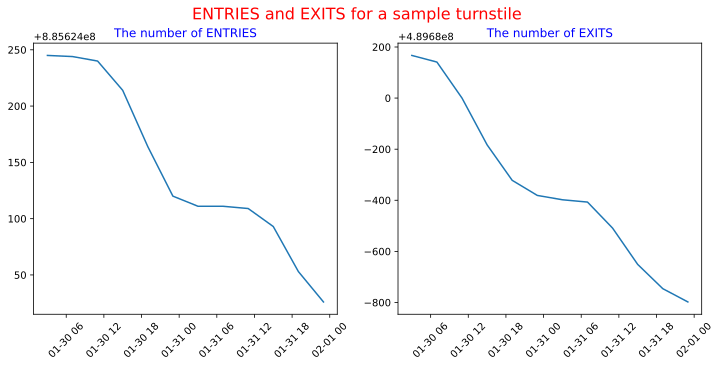

In [51]:
sample_turn1 = df[(df.TURNSTILE=='A011-R080-01-03-00')& ((df.DATE =='01/30/2021')|(df.DATE =='01/31/2021')) ][['TURNSTILE', 'DATE_TIME', 'ENTRIES','EXITS']]

plt.figure(figsize=[12,5])

plt.suptitle('ENTRIES and EXITS for a sample turnstile',fontsize = 16, color = 'red')

plt.subplot(1,2,1) # (number of rows, number of columns, number of plot)
plt.plot(sample_turn1['DATE_TIME'],sample_turn1['ENTRIES'])
plt.title('The number of ENTRIES', color = 'blue')
plt.xticks(rotation=45)


plt.subplot(1,2,2)
plt.plot(sample_turn1['DATE_TIME'],sample_turn1['EXITS'])
plt.title('The number of EXITS', color = 'blue')

plt.xticks(rotation=45);


#plt.title('ENTRIES and EXITS for a sample turnstile')
#plt.xlabel('Date_TIME')
#plt.ylabel('ENTRIES, EXITS');


#plt.legend(['ENTRIES, EXITS'],shadow = True, loc = 0);


In [52]:
df[(df.TURNSTILE=='A002-R051-02-03-02')& (df.DATE =='03/22/2021') ][['TURNSTILE', 'DATE_TIME', 'ENTRIES']].head(15)

TURNSTILE           DATE_TIME  ENTRIES
1883026  A002-R051-02-03-02 2021-03-22 20:00:00      238
1883025  A002-R051-02-03-02 2021-03-22 16:00:00       22
1883024  A002-R051-02-03-02 2021-03-22 12:00:00  6641481
1883023  A002-R051-02-03-02 2021-03-22 08:00:00  6641446
1883022  A002-R051-02-03-02 2021-03-22 04:00:00  6641440
1883021  A002-R051-02-03-02 2021-03-22 00:00:00  6641438

The above instances reveals some issues related to the data. For example, first sample data shows that time-stamp entries might be recorded reverse in order. Second example, on the other hand, shows that there might be a recording problem during audit. 

In [53]:
(mta_daily[(mta_daily["no_entry"] < 0) |(mta_daily['no_exits']<0)].groupby(['TURNSTILE'])).size()
   

TURNSTILE
A002-R051-02-03-02       1
A007-R079-01-05-01       1
A011-R080-01-03-00     118
A011-R080-01-03-03       1
A011-R080-01-03-04       1
                      ... 
R622-R123-00-00-00     118
R624-R124-00-00-02       1
R730-R431-00-00-04     117
S101-R070-00-00-04       1
TRAM2-R469-00-05-00      2
Length: 282, dtype: int64

There are total 282 records which have either negative number of entries or exits. The negative entries and outliers will be handled below. 

In [54]:
# Drop the rows for the earliest date in the df
mta_daily.dropna(subset=["no_entry"], axis=0, inplace=True)

In [55]:
mta_daily.head()

TURNSTILE STATION       DATE  ENTRIES    EXITS  no_entry  no_exits
1  A002-R051-02-00-00   59 ST 2021-01-31  7525089  2564914     268.0      91.0
2  A002-R051-02-00-00   59 ST 2021-02-01  7525260  2565032     171.0     118.0
3  A002-R051-02-00-00   59 ST 2021-02-02  7525600  2565208     340.0     176.0
4  A002-R051-02-00-00   59 ST 2021-02-03  7526164  2565484     564.0     276.0
5  A002-R051-02-00-00   59 ST 2021-02-04  7526683  2565733     519.0     249.0

In [56]:
def get_daily_counts(row,column, max_counter):
    '''
    Initial attempt at dealing with reversed counters
    '''
    
    counter = row[column]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        #print(f'entries: {row[column]}<--',counter )
    if counter > max_counter:
        # If counter (daily count) is > 1M, then the counter might have been reset.  
        # Set count to zero as different counters have different cycle limits
        #print(f'entries: {row[column]} ')

        return 0
    
    return counter



mta_daily['no_entry'] = mta_daily.apply(lambda row: get_daily_counts(row,'no_entry',1000000), axis=1)
mta_daily['no_exits'] = mta_daily.apply(lambda row: get_daily_counts(row,'no_exits',1000000), axis=1)

In [285]:
mta_daily['no_exits'] = mta_daily.apply(lambda row: get_daily_counts(row,'no_exits',1000000), axis=1)

In [286]:
#Sanity check
mta_daily.describe()

ENTRIES         EXITS       no_entry       no_exits
count  5.890380e+05  5.890380e+05  589038.000000  589038.000000
mean   4.189243e+07  3.367505e+07     389.326359     370.571547
std    2.182570e+08  1.934725e+08    6712.652001    4397.521262
min    0.000000e+00  0.000000e+00       0.000000       0.000000
25%    2.153345e+05  9.138100e+04      61.000000      58.000000
50%    1.451680e+06  8.652060e+05     212.000000     197.000000
75%    6.115799e+06  4.017902e+06     440.000000     454.000000
max    2.147432e+09  2.123038e+09  984026.000000  995298.000000

In [287]:
type(mta_daily)

pandas.core.frame.DataFrame

Now, all descriptive statistics are nonnegative and the quartile values look more consistent. However, there are still outliers (e.g. the maximum) which probably caused huge variability in the date (e.g. large standard deviation). 

Observing the descriptive statistics reveals that the outliers in the data create abnormalities ( i.e. skewness in the data, the maximum is about 147 times higher than the standard deviation, %50 is much lower than mean). Since this problem might most probably yields high bias in the further analysis, I remove the records beyond the 1.5 inter quartile range of the third quantile. After removing outliers, the statistics look aligned to each other. 

In [60]:
cols = ['no_entry', 'no_exits'] # one or more

Q1 = mta_daily[cols].quantile(0.25)
Q3 = mta_daily[cols].quantile(0.75)
IQR = Q3 - Q1

mta_daily_out = mta_daily[~(mta_daily[cols] > (Q3 + 1.5 * IQR)).any(axis=1)].copy() 
              
mta_daily_out.describe()

ENTRIES         EXITS       no_entry       no_exits
count  5.381200e+05  5.381200e+05  538120.000000  538120.000000
mean   4.042456e+07  3.210273e+07     248.456907     248.979334
std    2.136367e+08  1.870729e+08     236.406980     249.712058
min    0.000000e+00  0.000000e+00       0.000000       0.000000
25%    1.933600e+05  7.194225e+04      49.000000      47.000000
50%    1.281727e+06  7.319450e+05     188.000000     171.000000
75%    5.659920e+06  3.451587e+06     382.000000     377.000000
max    2.147432e+09  2.123038e+09    1008.000000    1048.000000

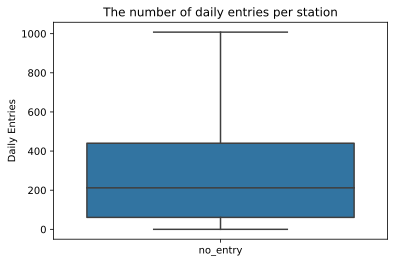

In [254]:
#Boxplot without outliers
sns.boxplot(
    data= pd.DataFrame(mta_daily, columns = ["no_entry"]),showfliers=False
).set_ylabel('Daily Entries')
plt.title("The number of daily entries per station")

plt.show()

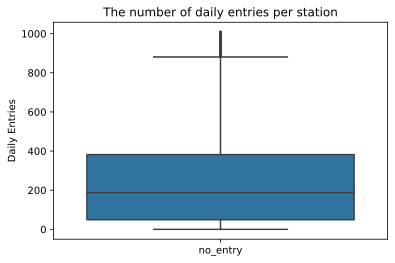

In [255]:
#Boxplot with outliers
sns.boxplot(
    data= pd.DataFrame(mta_daily_out, columns=["no_entry"]),fliersize = 1).set_ylabel('Daily Entries')
plt.title("The number of daily entries per station")

plt.show()

In [296]:
fig, ax =plt.subplots(1,2,figsize=(10, 7), sharex=True)
sns.despine(left=True)



sns.boxplot(
    data= pd.DataFrame(mta_daily_out, columns=["no_entry"]),ax=ax[0],fliersize = 1).set(xlabel='# of entries',xticklabels=[])
ax[0].set(ylabel='Daily Foot Traffic')
ax[0].set_title("The number of daily entries per station" )


sns.boxplot(
    data= pd.DataFrame(mta_daily_out, columns=["no_exits"]),ax=ax[1],fliersize = 1).set(xlabel='# of exits',xticklabels=[])
ax[1].set_title("The number of daily exits per station")

fig.show()
plt.savefig('daily_entry_exit.png');


<ipython-input-296-db9a8b1a4703>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


# The busiest stations

In [64]:
mta_daily_out.head()

TURNSTILE STATION       DATE  ENTRIES    EXITS  no_entry  no_exits
1  A002-R051-02-00-00   59 ST 2021-01-31  7525089  2564914     268.0      91.0
2  A002-R051-02-00-00   59 ST 2021-02-01  7525260  2565032     171.0     118.0
3  A002-R051-02-00-00   59 ST 2021-02-02  7525600  2565208     340.0     176.0
4  A002-R051-02-00-00   59 ST 2021-02-03  7526164  2565484     564.0     276.0
5  A002-R051-02-00-00   59 ST 2021-02-04  7526683  2565733     519.0     249.0

In [65]:
mta_daily_out['total'] = mta_daily_out['no_entry']+ mta_daily_out['no_exits']
mta_daily_out.head()


TURNSTILE STATION       DATE  ENTRIES    EXITS  no_entry  \
1  A002-R051-02-00-00   59 ST 2021-01-31  7525089  2564914     268.0   
2  A002-R051-02-00-00   59 ST 2021-02-01  7525260  2565032     171.0   
3  A002-R051-02-00-00   59 ST 2021-02-02  7525600  2565208     340.0   
4  A002-R051-02-00-00   59 ST 2021-02-03  7526164  2565484     564.0   
5  A002-R051-02-00-00   59 ST 2021-02-04  7526683  2565733     519.0   

   no_exits  total  
1      91.0  359.0  
2     118.0  289.0  
3     176.0  516.0  
4     276.0  840.0  
5     249.0  768.0

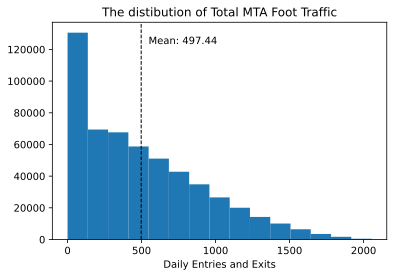

In [298]:
plt.hist(mta_daily_out['total'],bins=15);
plt.xlabel('Daily Entries and Exits')
#plt.ylabel('# of Stations')
plt.axvline(mta_daily_out['total'].mean(), color='k', linestyle='dashed', linewidth=1)

plt.title('The distibution of Total MTA Foot Traffic')
min_ylim, max_ylim = plt.ylim()
plt.text(mta_daily_out['total'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(mta_daily_out['total'].mean()))
plt.savefig('hist_total', dpi=300, bbox_inches='tight');

The histogram of the total traffic shows that the distribution is skewed right which means the majority of the data is towards the lower side. 

In [260]:
top_10_total =mta_daily_out.groupby(['STATION'])['total'].sum().reset_index().sort_values(['total'], ascending = False).head(10)
top_10_total


STATION      total
61    34 ST-PENN STA  6392855.0
46             23 ST  4625863.0
226        FULTON ST  4187728.0
110            86 ST  4001583.0
85             59 ST  3886947.0
59   34 ST-HERALD SQ  3639169.0
233  GRD CNTRL-42 ST  3493900.0
353   TIMES SQ-42 ST  3480180.0
173         CANAL ST  3372098.0
9             125 ST  3340551.0

In [297]:
#Sanity check: what if I use only entries not total
#Top 10 busiest stations are the exactly same, only order is different
mta_daily_out.groupby(['STATION'])['no_entry'].sum().reset_index().sort_values(['no_entry'], ascending = False).head(10)

STATION   no_entry
61    34 ST-PENN STA  3050415.0
46             23 ST  2331515.0
110            86 ST  2039079.0
226        FULTON ST  1916377.0
85             59 ST  1841393.0
59   34 ST-HERALD SQ  1735429.0
233  GRD CNTRL-42 ST  1633331.0
9             125 ST  1584969.0
173         CANAL ST  1560079.0
353   TIMES SQ-42 ST  1546050.0

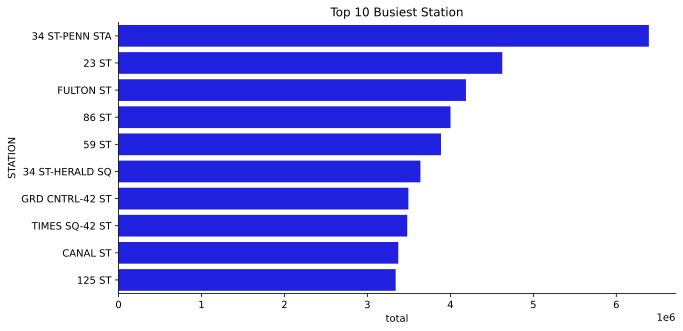

In [299]:
fig, ax = plt.subplots(figsize=(10, 5))


#sns.set_color_codes("pastel")
sns.barplot(x="total", y="STATION", data=top_10_total.sort_values(by = 'total',ascending=False),
            label="Total", color="b").set(title='Top 10 Busiest Station')

sns.despine()
plt.savefig('top_10_busy', dpi=500, bbox_inches='tight');

In [157]:
#Sanity check if there are different '59 St' stations, or the data combines all stations starting with '59 St'
mta_59 = (mta_daily_out[(mta_daily_out['STATION'].str.contains('59', regex=True))])

In [161]:
mta_59.groupby('STATION').count()

TURNSTILE  DATE  ENTRIES  EXITS  no_entry  no_exits  total  \
STATION                                                                      
5 AV/59 ST           1576  1576     1576   1576      1576      1576   1576   
59 ST                6091  6091     6091   6091      6091      6091   6091   
59 ST COLUMBUS       4165  4165     4165   4165      4165      4165   4165   

                weekday  
STATION                  
5 AV/59 ST         1576  
59 ST              6091  
59 ST COLUMBUS     4165

# The busiest day of the week

In [71]:
mta_daily_out['DATE'] = pd.to_datetime(mta_daily_out.DATE)


In [75]:

mta_daily_out['weekday'] = (mta_daily_out['DATE']).dt.day_name()
mta_daily_out['day_id'] = (mta_daily_out['DATE']).dt.dayofweek
mta_daily_out.head()


TURNSTILE STATION       DATE  ENTRIES    EXITS  no_entry  \
1  A002-R051-02-00-00   59 ST 2021-01-31  7525089  2564914     268.0   
2  A002-R051-02-00-00   59 ST 2021-02-01  7525260  2565032     171.0   
3  A002-R051-02-00-00   59 ST 2021-02-02  7525600  2565208     340.0   
4  A002-R051-02-00-00   59 ST 2021-02-03  7526164  2565484     564.0   
5  A002-R051-02-00-00   59 ST 2021-02-04  7526683  2565733     519.0   

   no_exits  total    weekday  day_id  
1      91.0  359.0     Sunday       6  
2     118.0  289.0     Monday       0  
3     176.0  516.0    Tuesday       1  
4     276.0  840.0  Wednesday       2  
5     249.0  768.0   Thursday       3

In [82]:
import calendar
mta_daily_out['weekday'] = pd.Categorical(mta_daily_out['weekday'], categories=list(calendar.day_name), ordered = True)


In [83]:
mta_daily_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538120 entries, 1 to 594096
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   TURNSTILE  538120 non-null  object        
 1   STATION    538120 non-null  object        
 2   DATE       538120 non-null  datetime64[ns]
 3   ENTRIES    538120 non-null  int64         
 4   EXITS      538120 non-null  int64         
 5   no_entry   538120 non-null  float64       
 6   no_exits   538120 non-null  float64       
 7   total      538120 non-null  float64       
 8   weekday    538120 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 37.5+ MB


In [84]:
mta_weekday = mta_daily_out[['no_entry', 'no_exits', 'total', 'weekday']].groupby('weekday').sum().reset_index()

In [85]:
mta_weekday

weekday    no_entry    no_exits       total
0     Monday  20067652.0  19605990.0  39673642.0
1    Tuesday  20894504.0  20191271.0  41085775.0
2  Wednesday  21318720.0  20520501.0  41839221.0
3   Thursday  21219401.0  20474327.0  41693728.0
4     Friday  21067435.0  20549440.0  41616875.0
5   Saturday  15774231.0  17150252.0  32924483.0
6     Sunday  13357688.0  15488978.0  28846666.0

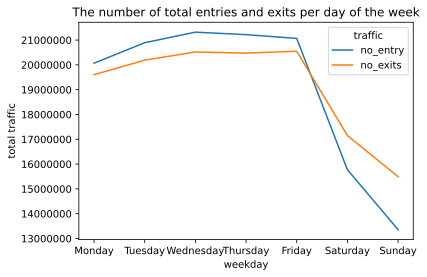

In [391]:
entry_exit_day = mta_weekday[['weekday', 'no_entry', 'no_exits']].melt('weekday', var_name='traffic', value_name='total traffic')
g = sns.lineplot(x="weekday", y='total traffic', hue='traffic', data=entry_exit_day)
plt.title("The number of total entries and exits per day of the week")

plt.ticklabel_format(style='plain', axis='y')

plt.savefig('day_of_week',dpi=300, bbox_inches='tight')
plt.show();

In [87]:
mta_weekday_median = mta_daily_out[['no_entry', 'no_exits', 'total', 'weekday']].groupby('weekday').median().reset_index().sort_values(by = 'weekday')
mta_weekday_median.head()

weekday  no_entry  no_exits  total
0     Monday     201.0     176.0  434.0
1    Tuesday     220.0     190.0  470.0
2  Wednesday     231.0     198.0  492.0
3   Thursday     228.0     196.0  487.0
4     Friday     226.0     198.0  488.0

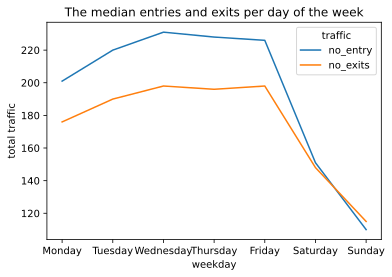

In [248]:
entry_exit_day_median = mta_weekday_median[['weekday', 'no_entry', 'no_exits']].melt('weekday', var_name='traffic', value_name='total traffic')
g = sns.lineplot(x="weekday", y='total traffic', hue='traffic', data=entry_exit_day_median)
plt.title("The median entries and exits per day of the week")

plt.ticklabel_format(style='plain', axis='y')
plt.show()



The total foot-traffic decreases significantly during the weekend. The midweek is the time that the subways have the highest traffic. 

In [389]:
mta1_top_10 = mta_daily_out[(mta_daily_out.STATION.isin(top_10_total.STATION))]

In [390]:
weekday_top_10= mta1_top_10[['no_entry', 'no_exits', 'total', 'weekday']].groupby('weekday').sum().reset_index()

In [ ]:
entry_exit_day = mta_weekday[['weekday', 'no_entry', 'no_exits']].melt('weekday', var_name='traffic', value_name='total traffic')
g = sns.lineplot(x="weekday", y='total traffic', hue='traffic', data=entry_exit_day)
plt.title("The number of entries and exits per day of the week")

plt.ticklabel_format(style='plain', axis='y')

plt.savefig('day_of_week',dpi=300, bbox_inches='tight')
plt.show();

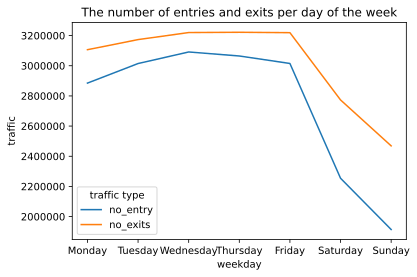

In [397]:
top_10_day = weekday_top_10[['weekday', 'no_entry', 'no_exits']].melt('weekday', var_name='traffic type', value_name='traffic')
g = sns.lineplot(x="weekday", y='traffic', hue='traffic type', data=top_10_day)
plt.title("The number of entries and exits per day of the week")

plt.ticklabel_format(style='plain', axis='y')

plt.savefig('day_of_week_top10',dpi=300, bbox_inches='tight')
plt.show();



# Deeper look at the busiest station :34 ST-PENN STA

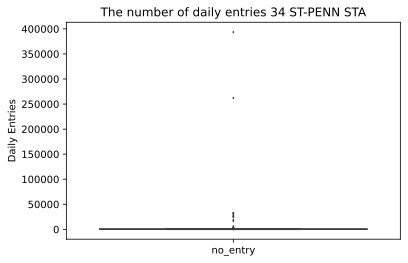

In [277]:
#Sanity check for Penn Sta
sample_turn2 = mta_daily[(mta_daily.STATION=='34 ST-PENN STA') ][['TURNSTILE','STATION', 'DATE', 'no_entry','no_exits']]
#Boxplot with outliers
sns.boxplot(
    data= pd.DataFrame(sample_turn2, columns=["no_entry"]),fliersize = 1).set_ylabel('Daily Entries')
plt.title("The number of daily entries 34 ST-PENN STA")

plt.show()

Too many outliers cause the box plot disappered.

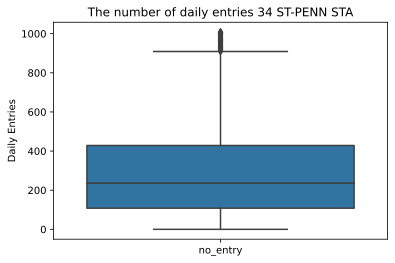

In [278]:
#Sanity check for Penn Sta
sample_turn2_out = mta_daily_out[(mta_daily_out.STATION=='34 ST-PENN STA') ][['TURNSTILE','STATION', 'DATE', 'no_entry','no_exits','total']]
#Boxplot with outliers
sns.boxplot(
    data= pd.DataFrame(sample_turn2_out, columns=["no_entry"])).set_ylabel('Daily Entries')
plt.title("The number of daily entries 34 ST-PENN STA")

plt.show()

In [279]:
#Sanity check for Penn Sta
sample_turn2_out.describe()


no_entry      no_exits         total
count  10847.000000  10847.000000  10847.000000
mean     281.221997    308.144187    589.366184
std      222.636688    241.581217    381.953230
min        0.000000      0.000000      0.000000
25%      108.000000    122.000000    306.500000
50%      236.000000    269.000000    583.000000
75%      428.500000    432.000000    859.000000
max     1008.000000   1047.000000   1970.000000

Checking the busiest turnstile at the Penn Station

In [280]:
turnstile_penn = sample_turn2_out.groupby(['TURNSTILE']).sum().reset_index()
#.sort_values(by = 'total', ascending = False)
turnstile_penn.head()



TURNSTILE  no_entry  no_exits    total
0  N067-R012-00-00-00   22605.0   68577.0  91182.0
1  N067-R012-00-00-01   21668.0   20265.0  41933.0
2  N067-R012-00-00-02   34642.0   25556.0  60198.0
3  N067-R012-00-00-03   47686.0   20952.0  68638.0
4  N067-R012-00-00-04   49983.0   41682.0  91665.0

In [281]:
turnstile_penn.groupby(['TURNSTILE']).count()

no_entry  no_exits  total
TURNSTILE                                    
N067-R012-00-00-00         1         1      1
N067-R012-00-00-01         1         1      1
N067-R012-00-00-02         1         1      1
N067-R012-00-00-03         1         1      1
N067-R012-00-00-04         1         1      1
...                      ...       ...    ...
R142-R293-01-00-01         1         1      1
R142-R293-01-00-02         1         1      1
R142-R293-01-00-03         1         1      1
R142-R293-01-06-00         1         1      1
R142-R293-01-06-01         1         1      1

[103 rows x 3 columns]

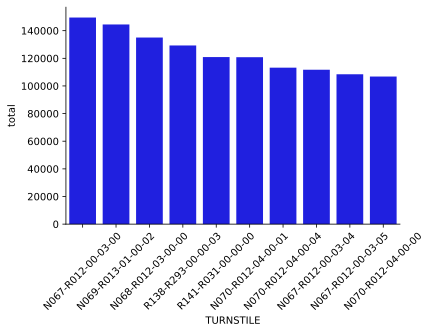

In [282]:
#fig, ax = plt.subplots(figsize=(10, 5))

#sns.set_color_codes("pastel")
sns.barplot(y="total", x="TURNSTILE", data=turnstile_penn.sort_values(by = 'total',ascending=False).head(10),
            label="Total", color="b")
plt.xticks(rotation=45)
sns.despine();


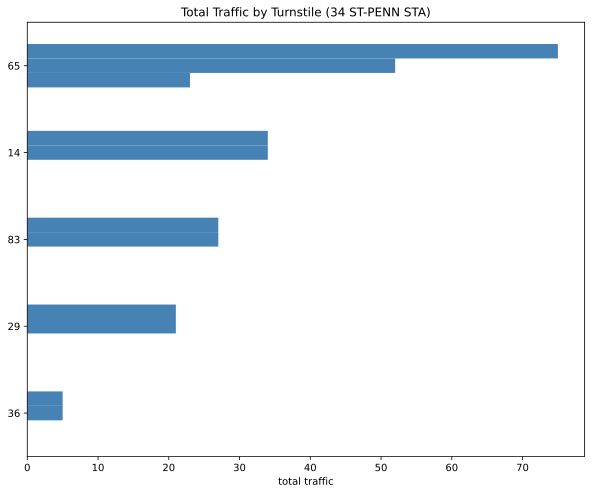

In [283]:
fig, ax = plt.subplots(figsize=(10, 8))
turnstile_penn.sort_values(by = 'total',ascending=True).head(5).plot(kind='barh', color ='steelblue',ax=ax)
ax.set(title='Total Traffic by Turnstile (34 ST-PENN STA)', xlabel='total traffic', ylabel='')
ax.legend().set_visible(False)

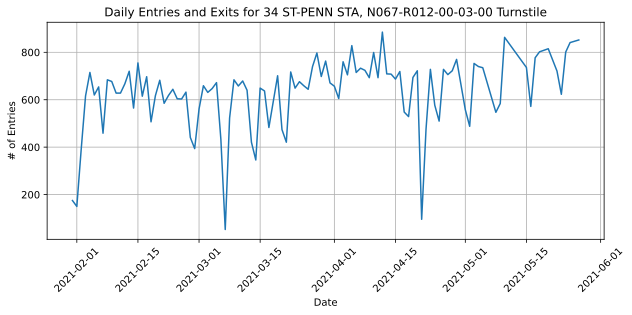

In [284]:
plt.figure(figsize=(10, 4))
plt.plot(sample_turn2_out[(sample_turn2_out['TURNSTILE'] == 'N067-R012-00-03-00')]['DATE'], sample_turn2_out[(sample_turn2_out['TURNSTILE'] == 'N067-R012-00-03-00')]['no_entry'])
plt.ylabel('# of Entries')

#plt.plot(sample_turn2_out['DATE'], sample_turn2_out['no_exits'])
#plt.ylabel('# of Exits')

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid()
plt.title('Daily Entries and Exits for 34 ST-PENN STA, N067-R012-00-03-00 Turnstile');


# Busiest time of the day

The current version of the data has the cumulative entry and exit register values for a device which normally occurs every 4 hours. The differences between every two subsequent DATE_TIME value of ENTRIES and EXITS will be used as the number of entries and exits records per time interval. 
I will look further to see if there are any unusual entries and exits records per time interval. 

In [203]:
df_sorted = df.sort_values(['TURNSTILE','DATE_TIME'],ascending = (True, True)).reset_index(drop = True)
df_sorted.head()

C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  03:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  07:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  11:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  15:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  19:00:00   

         DESC  ENTRIES    EXITS           DATE_TIME           TURNSTILE  
0     REGULAR  7524539  2564693 2021-01-30 03:00:00  A002-R051-02-00-00  
1     REGULAR  7524543  2564703 2021-01-30 07:00:00  A002-R051-02-00-00  
2     REGULAR  7524566  2564755 2021-01-30 11:00:00  A002-R051-02-00-00  
3  RECOVR AUD  7524643  2564793 2021-01-30 15:00:00  A002-R051-02-00-00  
4     REGULAR  7524739  2564811 2021-01-30 19:00:00  A002-R051-02-00-00

In [204]:
df_sorted['entry']= df_sorted.groupby(['TURNSTILE'])['ENTRIES'].diff()
df_sorted.head(10)



C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  03:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  07:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  11:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  15:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  19:00:00   
5  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  23:00:00   
6  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/31/2021  03:00:00   
7  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/31/2021  07:00:00   
8  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/31/2021  11:00:00   
9  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/31/2021  15:00:00   

         DESC  ENTRIES    EXITS           DATE_TIME           TURNSTILE  entry  
0     REGULAR  7524539  2564693 2021-01-30 03:00:00  A002-R051-02-00-00    NaN  
1     REGULAR  7524543  2564703 2021-01-30 07:00:00  A002-R051-02-00-00    4.0  
2     REGULAR  7524566  2564755 2021-01-30 11:00:00  A002-R051-02-00-00   23.0  
3  RECOVR AUD  7524643  2564793 2021-01-30 15:00:00  A002-R051-02-00-00   77.0  
4     REGULAR  7524739  2564811 2021-01-30 19:00:00  A002-R051-02-00-00   96.0  
5     REGULAR  7524821  2564823 2021-01-30 23:00:00  A002-R051-02-00-00   82.0  
6     REGULAR  7524826  2564825 2021-01-31 03:00:00  A002-R051-02-00-00    5.0  
7     REGULAR  7524828  2564827 2021-01-31 07:00:00  A002-R051-02-00-00    2.0  
8     REGULAR  7524851  2564858 2021-01-31 11:00:00  A002-R051-02-00-00   23.0  
9     REGULAR  7524927  2564880 2021-01-31 15:00:00  A002-R051-02-00-00   76.0

In [205]:
df_sorted['exit']= df_sorted.sort_values(['TURNSTILE','DATE_TIME'],ascending = (False, True)).groupby(['TURNSTILE'])['EXITS'].diff()
df_sorted.head(10)


C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  03:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  07:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  11:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  15:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  19:00:00   
5  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/30/2021  23:00:00   
6  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/31/2021  03:00:00   
7  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/31/2021  07:00:00   
8  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/31/2021  11:00:00   
9  A002  R051  02-00-00   59 ST  NQR456W      BMT  01/31/2021  15:00:00   

         DESC  ENTRIES    EXITS           DATE_TIME           TURNSTILE  \
0     REGULAR  7524539  2564693 2021-01-30 03:00:00  A002-R051-02-00-00   
1     REGULAR  7524543  2564703 2021-01-30 07:00:00  A002-R051-02-00-00   
2     REGULAR  7524566  2564755 2021-01-30 11:00:00  A002-R051-02-00-00   
3  RECOVR AUD  7524643  2564793 2021-01-30 15:00:00  A002-R051-02-00-00   
4     REGULAR  7524739  2564811 2021-01-30 19:00:00  A002-R051-02-00-00   
5     REGULAR  7524821  2564823 2021-01-30 23:00:00  A002-R051-02-00-00   
6     REGULAR  7524826  2564825 2021-01-31 03:00:00  A002-R051-02-00-00   
7     REGULAR  7524828  2564827 2021-01-31 07:00:00  A002-R051-02-00-00   
8     REGULAR  7524851  2564858 2021-01-31 11:00:00  A002-R051-02-00-00   
9     REGULAR  7524927  2564880 2021-01-31 15:00:00  A002-R051-02-00-00   

   entry  exit  
0    NaN   NaN  
1    4.0  10.0  
2   23.0  52.0  
3   77.0  38.0  
4   96.0  18.0  
5   82.0  12.0  
6    5.0   2.0  
7    2.0   2.0  
8   23.0  31.0  
9   76.0  22.0

In [174]:
top_10_total.STATION

61      34 ST-PENN STA
46               23 ST
226          FULTON ST
110              86 ST
85               59 ST
59     34 ST-HERALD SQ
233    GRD CNTRL-42 ST
353     TIMES SQ-42 ST
173           CANAL ST
9               125 ST
Name: STATION, dtype: object

In [207]:
df_top_10 = df_sorted[(df_sorted.STATION.isin(top_10_total.STATION))]

In [208]:
df_top_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482967 entries, 0 to 2962121
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   C/A        482967 non-null  object        
 1   UNIT       482967 non-null  object        
 2   SCP        482967 non-null  object        
 3   STATION    482967 non-null  object        
 4   LINENAME   482967 non-null  object        
 5   DIVISION   482967 non-null  object        
 6   DATE       482967 non-null  object        
 7   TIME       482967 non-null  object        
 8   DESC       482967 non-null  object        
 9   ENTRIES    482967 non-null  int64         
 10  EXITS      482967 non-null  int64         
 11  DATE_TIME  482967 non-null  datetime64[ns]
 12  TURNSTILE  482967 non-null  object        
 13  entry      482265 non-null  float64       
 14  exit       482265 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(10)
memory usage

In [217]:
df_top_10['DATE'] = pd.to_datetime(df_top_10.DATE)
df_top_10['hour'] = df_top_10['DATE_TIME'].dt.time


In [210]:
df_top_10.describe()

ENTRIES         EXITS         entry          exit
count  4.829670e+05  4.829670e+05  4.822650e+05  4.822650e+05
mean   5.276395e+07  5.524521e+07  1.203705e+03  9.028229e+02
std    2.428196e+08  2.550363e+08  1.563995e+06  3.614821e+06
min    0.000000e+00  0.000000e+00 -3.156055e+08 -1.508657e+09
25%    3.134065e+05  1.733445e+05  3.000000e+00  6.000000e+00
50%    1.969210e+06  1.434591e+06  2.100000e+01  2.900000e+01
75%    7.506686e+06  5.349262e+06  7.100000e+01  8.500000e+01
max    2.000301e+09  2.049252e+09  1.036126e+09  2.005378e+09

In [211]:
df_top_10['entry'] = df_top_10.apply(lambda row: get_daily_counts(row,'entry',1000000), axis=1)
df_top_10['exit'] = df_top_10.apply(lambda row: get_daily_counts(row,'exit',1000000), axis=1)

<ipython-input-211-4c3b3170a25f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['entry'] = df_top_10.apply(lambda row: get_daily_counts(row,'entry',1000000), axis=1)
<ipython-input-211-4c3b3170a25f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['exit'] = df_top_10.apply(lambda row: get_daily_counts(row,'exit',1000000), axis=1)


In [214]:
cols = ['entry', 'exit'] # one or more

Q1 = df_top_10[cols].quantile(0.25)
Q3 = df_top_10[cols].quantile(0.75)
IQR = Q3 - Q1

df_top_10 = df_top_10[~(df_top_10[cols] > (Q3 + 1.5 * IQR)).any(axis=1)].copy() 
              
df_top_10.describe()

ENTRIES         EXITS          entry           exit
count  4.190280e+05  4.190280e+05  418326.000000  418326.000000
mean   4.917936e+07  5.091406e+07      33.767918      41.116703
std    2.335758e+08  2.425568e+08      41.817967      48.450409
min    0.000000e+00  0.000000e+00       0.000000       0.000000
25%    2.758768e+05  1.323518e+05       2.000000       4.000000
50%    1.808160e+06  1.192752e+06      15.000000      21.000000
75%    6.860507e+06  4.773188e+06      52.000000      62.000000
max    2.000301e+09  2.049251e+09     175.000000     206.000000

In [215]:
# Drop the rows for the earliest date in the df
df_top_10.dropna(subset=["entry",'exit'], axis=0, inplace=True)

In [221]:
df_top_10['Total'] = df_top_10['entry'] +df_top_10['exit'] 


In [252]:
df_top_10['weekday'] = (df_top_10['DATE']).dt.day_name()
df_top_10['weekday'] = pd.Categorical(df_top_10['weekday'], categories=list(calendar.day_name), ordered = True)


In [264]:
#check only midweeks, since the total traffic is the highest on Wednesday
top_10_week = df_top_10[(df_top_10.weekday == 'Wednesday')| (df_top_10.weekday == 'Thursday')| (df_top_10.weekday == 'Friday')]
top_10_group = df_top_10.groupby(['STATION','hour'])['Total'].mean().reset_index()
top_10_group




STATION      hour       Total
0            125 ST  00:00:00  130.750558
1            125 ST  01:00:00  111.365059
2            125 ST  03:00:00   34.854875
3            125 ST  04:00:00   25.505623
4            125 ST  05:00:00   19.499383
..              ...       ...         ...
344  TIMES SQ-42 ST  15:00:00  139.630788
345  TIMES SQ-42 ST  16:00:00  163.697382
346  TIMES SQ-42 ST  19:00:00  166.523932
347  TIMES SQ-42 ST  20:00:00  177.199234
348  TIMES SQ-42 ST  23:00:00   97.607205

[349 rows x 3 columns]

In [321]:
df_time = top_10_group
df_time

STATION      hour       Total  mean_traffic
0            125 ST  00:00:00  130.750558    124.011520
1            125 ST  01:00:00  111.365059    124.011520
2            125 ST  03:00:00   34.854875    124.011520
3            125 ST  04:00:00   25.505623    124.011520
4            125 ST  05:00:00   19.499383    124.011520
..              ...       ...         ...           ...
344  TIMES SQ-42 ST  15:00:00  139.630788     84.745019
345  TIMES SQ-42 ST  16:00:00  163.697382     84.745019
346  TIMES SQ-42 ST  19:00:00  166.523932     84.745019
347  TIMES SQ-42 ST  20:00:00  177.199234     84.745019
348  TIMES SQ-42 ST  23:00:00   97.607205     84.745019

[349 rows x 4 columns]

In [322]:
df_time['mean_traffic'] = df_time.groupby(['STATION'])['Total'].transform('mean')


In [323]:
df_time

STATION      hour       Total  mean_traffic
0            125 ST  00:00:00  130.750558    124.011520
1            125 ST  01:00:00  111.365059    124.011520
2            125 ST  03:00:00   34.854875    124.011520
3            125 ST  04:00:00   25.505623    124.011520
4            125 ST  05:00:00   19.499383    124.011520
..              ...       ...         ...           ...
344  TIMES SQ-42 ST  15:00:00  139.630788     84.745019
345  TIMES SQ-42 ST  16:00:00  163.697382     84.745019
346  TIMES SQ-42 ST  19:00:00  166.523932     84.745019
347  TIMES SQ-42 ST  20:00:00  177.199234     84.745019
348  TIMES SQ-42 ST  23:00:00   97.607205     84.745019

[349 rows x 4 columns]

In [350]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          349 non-null    object 
 1   hour             349 non-null    object 
 2   Total            349 non-null    float64
 3   mean_traffic     349 non-null    float64
 4   traffic_density  349 non-null    object 
dtypes: float64(2), object(3)
memory usage: 13.8+ KB


In [327]:
# create a list of our conditions
conditions = [
    (df_time['Total'] >= df_time['mean_traffic']),
    (df_time['Total'] < df_time['mean_traffic']),
    ]

# create a list of the values we want to assign for each condition
values = ['Above_avg', 'Below_avg']

# create a new column and use np.select to assign values to it using our lists as arguments
df_time['traffic_density'] = np.select(conditions, values)
df_time.head()

STATION      hour       Total  mean_traffic traffic_density
0  125 ST  00:00:00  130.750558     124.01152       Above_avg
1  125 ST  01:00:00  111.365059     124.01152       Below_avg
2  125 ST  03:00:00   34.854875     124.01152       Below_avg
3  125 ST  04:00:00   25.505623     124.01152       Below_avg
4  125 ST  05:00:00   19.499383     124.01152       Below_avg

In [387]:
%%capture cap --no-stderr

for i, group in df_time.groupby('STATION'):
    print((group[group['traffic_density']=='Above_avg']))
    

with open('output.txt', 'w') as f:
    f.write(str(cap()))

In [385]:
cap()

   STATION      hour       Total  mean_traffic traffic_density
0   125 ST  00:00:00  130.750558     124.01152       Above_avg
6   125 ST  07:37:21  169.428571     124.01152       Above_avg
8   125 ST  08:45:09  164.000000     124.01152       Above_avg
9   125 ST  09:00:00  150.211610     124.01152       Above_avg
12  125 ST  11:00:00  141.539611     124.01152       Above_avg
13  125 ST  12:00:00  180.500000     124.01152       Above_avg
14  125 ST  13:00:00  198.397260     124.01152       Above_avg
15  125 ST  15:00:00  141.276563     124.01152       Above_avg
16  125 ST  16:00:00  204.699568     124.01152       Above_avg
17  125 ST  17:00:00  186.874751     124.01152       Above_avg
18  125 ST  19:00:00  161.723048     124.01152       Above_avg
19  125 ST  20:00:00  199.987024     124.01152       Above_avg
21  125 ST  21:00:00  202.626898     124.01152       Above_avg
   STATION      hour       Total  mean_traffic traffic_density
23   23 ST  00:00:00   63.723529        54.946       Ab

In [378]:
stat_125=(df_time[(df_time['traffic_density']=='Above_avg') & (df_time['STATION']=='125 ST')])
#sns.barplot(x= 'traffic_density', y='hour', data=stat_125).set(title='')
stat_125.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 21
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          13 non-null     object 
 1   hour             13 non-null     object 
 2   Total            13 non-null     float64
 3   mean_traffic     13 non-null     float64
 4   traffic_density  13 non-null     object 
dtypes: float64(2), object(3)
memory usage: 624.0+ bytes


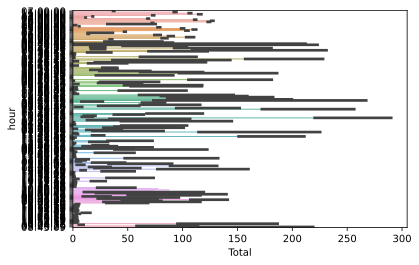

In [375]:
sns.barplot(x= 'Total', y='hour', data=df_top_10).set(title='')

plt.savefig('hist_time', dpi=500, bbox_inches='tight');

In [262]:
 #Pivot table for heatmap
heatmap1=top_10_group.set_index(['STATION', 'hour']).Total.unstack(0) 
heatmap1.head()

STATION       125 ST      23 ST  34 ST-HERALD SQ  34 ST-PENN STA      59 ST  \
hour                                                                          
00:00:00  130.750558  63.723529       103.228829       69.009840  67.141890   
01:00:00  111.365059  41.131886              NaN       52.072368        NaN   
02:00:00         NaN        NaN              NaN       49.346360        NaN   
03:00:00   34.854875  13.327526        22.390115       15.665217  17.839286   
04:00:00   25.505623   7.766964        15.930959       10.323293  11.113283   

STATION       86 ST   CANAL ST  FULTON ST  GRD CNTRL-42 ST  TIMES SQ-42 ST  
hour                                                                        
00:00:00  79.452902  43.504682  44.780045        40.698684      115.478491  
01:00:00  59.359433  43.769125  36.622365        32.436145             NaN  
02:00:00        NaN        NaN  17.826193              NaN             NaN  
03:00:00  17.675978  10.066416  13.832718        18.404393       25.492000  
04:00:00   9.550427   5.989420   5.582836         8.446361       21.972362

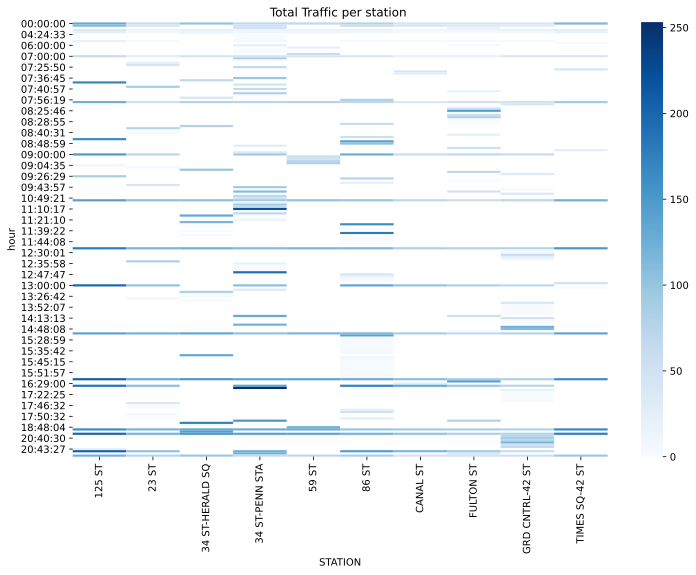

In [330]:
#Heatmap graph DAY, TIME and Total

fig, ax = plt.subplots(figsize=(12, 8))
ax.set(title='Total Traffic per station ', xlabel='', ylabel='Time')
sns.heatmap(heatmap1,ax=ax, cmap='Blues')
plt.savefig('heatmap', dpi=300, bbox_inches='tight')
plt.show();


# Parts not used for EDA

The first entry/exit data for each turnstile should be NaN values. 

In [206]:
#Sanity check
print('The following three numbers \n-the number of unique turnstile, the number of NaN values in entry and exit columns-\n should be equal. ')
print(len(df_sorted['TURNSTILE'].unique()))
print(df_sorted['entry'].isna().sum())
print(df_sorted['exit'].isna().sum())

The following three numbers 
-the number of unique turnstile, the number of NaN values in entry and exit columns-
 should be equal. 
5059
5059
5059


Let's investigate the descriptive statistics of entry and exit columns which represent the number of entries and exits per time interval. These statistics show that the records have several issues that need to be addressed. 
First of all, the average values of entry and exit are negative which is not possible for the records which represent the number of occurences. This shows that ENTRIES (EXITS) values which should be cumulative recorded missing. Moreover, as observed before, the maximum records are abnormally higher than the rest of the data.  

In [ ]:
df_sorted.describe()

In [ ]:
#df_sorted[(df_sorted.entry<0) | (df_sorted.exit<0)].sort_values('DATE_TIME')[['TURNSTILE','DATE','TIME','ENTRIES','EXITS']]

In [ ]:
neg =df_sorted[(df_sorted.entry<0)][['TURNSTILE','DATE']].


In [ ]:
neg.drop_duplicates(subset=['TURNSTILE','DATE'], inplace=True)
neg

In [ ]:
#[df_sorted[(df_sorted.TURNSTILE== turn) & (df_sorted.DATE ==date)]['ENTRIES'].sort_values(ascending=True).tolist() for turn, date in zip(neg['TURNSTILE'], df['DATE'])]

for ind in neg.index:
    df_sorted[(df_sorted.TURNSTILE== neg['TURNSTILE'][ind]) & (df_sorted.DATE ==neg['DATE'][ind])]['ENTRIES'].sort_values(ascending=True)

In [ ]:
df_sorted[(df_sorted.TURNSTILE=='R304-R206-00-00-00') & (df_sorted.DATE <='01/31/2021')& (df_sorted.DATE >= '01/29/2021')][['TURNSTILE','DATE','TIME','ENTRIES','EXITS','entry','exit']]

In [ ]:
#dummy['ENTRIES'] = dummy['ENTRIES'].sort_values(ascending=True).tolist()
#dummy



In [ ]:
#The maximum entry 
df_sorted[df_sorted.entry == df_sorted.entry.max()][['TURNSTILE','DATE','TIME','ENTRIES','EXITS']]

In [ ]:
df_sorted[(df_sorted.TURNSTILE=='J003-R352-00-00-00') & (df_sorted.DATE <='03/22/2021')& (df_sorted.DATE >= '03/21/2021')].sort_values('DATE_TIME')[['TURNSTILE','DATE','TIME','ENTRIES','EXITS']]

The maximum entry recorded at Hewes St on 04/16/2021. Observing the records on 04/16/2021 and later with the previous date shows that there might be a recording error at the corresponding audit (the value is about 250 times higher than the average entry of the station). 
The similar issue is observed for the maximum record of the exit value. 

In [ ]:
#The maximum exit 
df_sorted[df_sorted.exit == df_sorted.exit.max()]

In [ ]:
df_sorted[(df_sorted.TURNSTILE=='R258-R132-00-06-02') & (df_sorted.DATE <='04/15/2021')& (df_sorted.DATE >= '04/13/2021') ]

In [ ]:
print('The number of negative entry values:')
len(df_sorted['entry'][df_sorted['entry'] < 0])


In [ ]:
print('The number of negative exit values:')
len(df_sorted['exit'][df_sorted['exit'] < 0])